# Imporant pixels

You are given a pipeline that trains a fully convolutional autoencoder on the MNIST dataset. The model should train in under 2 minutes and give decent results (mean reconstruction loss <35).

Your task is to write a function that for a given input image and output pixel coordinates produces a list of input pixels that have non-zero contribution to the value of the output pixel. You should measure each pixel's contribution by setting it to the minimal and maximal value over the whole image.


Training pipeline (DO NOT CHANGE THIS SECTION)

In [1]:
import typing
import os
import random
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [2]:
epochs = 5
batch_size = 250
learning_rate = 1e-2
log_interval = 40

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Binarize:
    def __call__(self, sample):
        return torch.bernoulli(sample)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    Binarize(),
    transforms.Normalize([0.5], [0.5])
])

train = MNIST('./data', train=True, transform=img_transform, download=True)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = MNIST('./data', train=False, transform=img_transform, download=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.89MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.23MB/s]


In [4]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(
            1,
            16,
            kernel_size=(3, 3),
            padding=1,
            stride=1,
            bias=False,
        ),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Conv2d(
            16,
            32,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Conv2d(
            32,
            64,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                64,
                32,
                7,
                2,
                0,
                bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                32,
                16,
                3,
                1,
                0,
                bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                16,
                8,
                5,
                1,
                0,
                bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                8,
                1,
                4,
                1,
                0,
                bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data, reduction="sum")
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / data.size(0)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, data, reduction='sum').item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))



In [6]:
model = FCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 1198.498125
Train Epoch: 1 [10000/60000 (17%)]	Loss: 197.199094
Train Epoch: 1 [20000/60000 (33%)]	Loss: 149.887563
Train Epoch: 1 [30000/60000 (50%)]	Loss: 138.795187
Train Epoch: 1 [40000/60000 (67%)]	Loss: 101.322406
Train Epoch: 1 [50000/60000 (83%)]	Loss: 95.601484

Test set: Average loss: 89.6526

Train Epoch: 2 [0/60000 (0%)]	Loss: 88.414539
Train Epoch: 2 [10000/60000 (17%)]	Loss: 77.472898
Train Epoch: 2 [20000/60000 (33%)]	Loss: 79.916922
Train Epoch: 2 [30000/60000 (50%)]	Loss: 71.390719
Train Epoch: 2 [40000/60000 (67%)]	Loss: 64.809562
Train Epoch: 2 [50000/60000 (83%)]	Loss: 69.409125

Test set: Average loss: 63.1344

Train Epoch: 3 [0/60000 (0%)]	Loss: 61.673016
Train Epoch: 3 [10000/60000 (17%)]	Loss: 57.370688
Train Epoch: 3 [20000/60000 (33%)]	Loss: 55.558109
Train Epoch: 3 [30000/60000 (50%)]	Loss: 53.907016
Train Epoch: 3 [40000/60000 (67%)]	Loss: 60.220164
Train Epoch: 3 [50000/60000 (83%)]	Loss: 48.916164

Test set: Average loss

# Important pixels

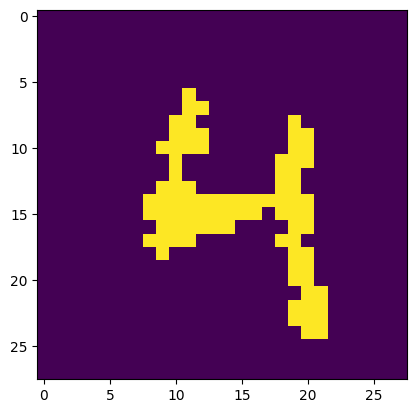

In [7]:
input_batch = next(iter(train_loader))[0][0,:].unsqueeze(0)
input_batch = input_batch.to(device)
plt.imshow(input_batch[0, :].cpu().detach().squeeze().numpy())

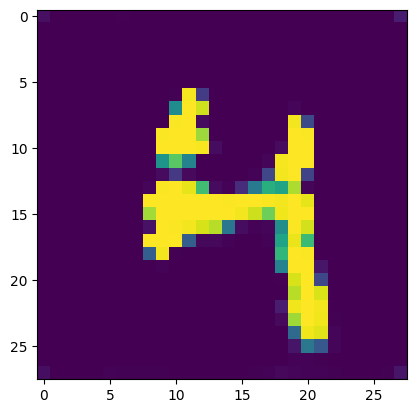

In [8]:
plt.imshow(model(input_batch)[0, :].cpu().detach().squeeze().numpy())

In [62]:
def important_pixels(input_batch: torch.Tensor, model: torch.nn.Module, device: torch.device, coordinates: typing.Tuple[int, int]) -> typing.Set[typing.Tuple[int,int]]:
    # 1. Setup
    model = model.to(device)
    input_batch = input_batch.to(device)
    model.eval()

    # 2. Correct Dimensions
    # N, C, H, W. Note: H is index 2, W is index 3.
    H, W = input_batch.size()[2], input_batch.size()[3]

    # 3. Dynamic Min/Max (Crucial for correct perturbation)
    min_val = input_batch.min()
    max_val = input_batch.max()

    # Target coordinates (x=col, y=row)
    target_x, target_y = coordinates

    # We will accumulate important pixels here.
    # Using a set directly avoids the need for a tensor map.
    important_pixels_set = set()

    for im in input_batch:
        # Iterate Rows (y) and Cols (x)
        for row in range(H):
            for col in range(W):

                # Perturb to MIN
                im_replaced_min = im.clone()
                im_replaced_min[0, row, col] = min_val

                # Perturb to MAX
                im_replaced_max = im.clone()
                im_replaced_max[0, row, col] = max_val

                # Batch the two variations to save time (2 forward passes -> 1 forward pass)
                batch_stack = torch.stack([im_replaced_min, im_replaced_max])

                with torch.no_grad():
                    out = model(batch_stack)
                    if isinstance(out, dict):
                        out = out['out']

                    # Output shape: [2, 1, H, W]
                    pred_min = out[0, 0]
                    pred_max = out[1, 0]

                # 4. Correct Output Indexing [row, col] -> [target_y, target_x]
                diff = torch.abs(pred_min[target_y, target_x] - pred_max[target_y, target_x])

                if diff > 1e-3:
                    # Return (x, y) which is (col, row)
                    important_pixels_set.add((col, row))

    return important_pixels_set

In [65]:
checked_pixel = (20, 20)
pixels = important_pixels(input_batch, model, device, checked_pixel)
pixels

{(9, 24),
 (9, 25),
 (10, 25),
 (11, 23),
 (11, 24),
 (11, 25),
 (12, 19),
 (12, 20),
 (12, 24),
 (12, 25),
 (12, 26),
 (13, 18),
 (13, 19),
 (13, 20),
 (13, 22),
 (13, 23),
 (13, 24),
 (13, 25),
 (13, 26),
 (13, 27),
 (14, 18),
 (14, 19),
 (14, 20),
 (14, 23),
 (14, 24),
 (14, 25),
 (14, 27),
 (15, 16),
 (15, 17),
 (15, 19),
 (15, 20),
 (15, 22),
 (15, 24),
 (15, 25),
 (15, 26),
 (15, 27),
 (16, 17),
 (16, 18),
 (16, 19),
 (16, 20),
 (16, 21),
 (16, 22),
 (16, 23),
 (16, 24),
 (16, 25),
 (16, 27),
 (17, 16),
 (17, 17),
 (17, 18),
 (17, 19),
 (17, 21),
 (17, 22),
 (17, 24),
 (17, 25),
 (18, 16),
 (18, 17),
 (18, 18),
 (18, 19),
 (18, 20),
 (18, 21),
 (18, 22),
 (18, 23),
 (18, 24),
 (18, 25),
 (18, 26),
 (18, 27),
 (19, 13),
 (19, 14),
 (19, 16),
 (19, 17),
 (19, 18),
 (19, 20),
 (19, 22),
 (19, 23),
 (19, 24),
 (19, 25),
 (20, 16),
 (20, 17),
 (20, 19),
 (20, 20),
 (20, 21),
 (20, 22),
 (20, 23),
 (20, 24),
 (20, 26),
 (21, 12),
 (21, 15),
 (21, 17),
 (21, 18),
 (21, 19),
 (21, 20),
 

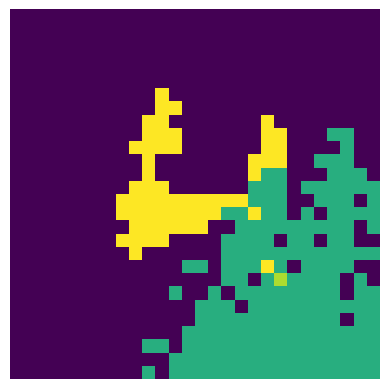

In [66]:
input_image_numpy = input_batch[0, :].cpu().detach().squeeze().numpy()

for pixel in pixels:
    input_image_numpy[pixel[0], pixel[1]] = 0.25

input_image_numpy[checked_pixel[0], checked_pixel[1]] = 0.75

plt.imshow(input_image_numpy)
plt.axis("off")
plt.show()